In [1]:
# data exploration
import pandas as pd
import numpy as np
from scipy.stats import skew

# data visualisation
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# plots settings
sns.set(rc={'figure.figsize': (20, 5)})

# statistical model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# packs for ML restricted area
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, LassoCV

## 1. Data Reading

In [2]:
# qog and polity dataset
url_qog = "https://raw.githubusercontent.com/edoardochiarotti/class_datascience/main/Notebooks/Assignment/individual_assignment/clean_data_prepared_EDA/df_qog_polity_merged.csv"
qog_df = pd.read_csv(url_qog, encoding='latin-1')
qog_df_subset = qog_df.loc[:, ('country', 'year', 'ccodealp_year', 'epi_ghp', 'ccl_nmitlp', 'polity2')]
qog_df_subset = qog_df_subset.dropna()

# qog_df_subset

In [3]:
# gdp dataset
url_gdp = "https://raw.githubusercontent.com/mivelikikh/qog_group_project/main/gdp_var.csv?token=GHSAT0AAAAAAB3TL6UXLWLJFG5FYD3FHPXAY5AYA2Q"
gdp_df = pd.read_csv(url_gdp, sep=';')
gdp_df = gdp_df.loc[:, ('ccodealp_year', 'gle_cgdpc')]
gdp_df = gdp_df.dropna()

# gdp_df

In [4]:
# Merge the two dataframes on the 'ccodealp_year' column
df = pd.merge(qog_df_subset, gdp_df, how='right', on='ccodealp_year')
df = df.dropna()
df = df.reset_index()
df

index  country    year ccodealp_year    epi_ghp  ccl_nmitlp  polity2  \
0       115  Albania  2003.0         ALB03  62.423880         1.0      7.0   
1       116  Albania  2004.0         ALB04  63.066149         1.0      7.0   
2       117  Albania  2005.0         ALB05  62.657502         1.0      9.0   
3       118  Albania  2006.0         ALB06  63.926970         1.0      9.0   
4       119  Albania  2007.0         ALB07  64.317704         1.0      9.0   
...     ...      ...     ...           ...        ...         ...      ...   
1719   9378   Zambia  2007.0         ZMB07  66.989888         2.0      5.0   
1720   9379   Zambia  2008.0         ZMB08  67.292225         4.0      7.0   
1721   9380   Zambia  2009.0         ZMB09  69.323288         4.0      7.0   
1722   9381   Zambia  2010.0         ZMB10  67.606317         5.0      7.0   
1723   9382   Zambia  2011.0         ZMB11  68.817045         6.0      7.0   

     gle_cgdpc  
0      4803,28  
1      5111,77  
2      5533,09  
3      6072,21  
4      6537,80  
...        ...  
1719   1628,14  
1720   1657,15  
1721   1810,42  
1722   1875,52  
1723   1916,79  

[1724 rows x 8 columns]

for automatisation we will use the following variables instead of real names:

In [5]:
exp_feature_1 = 'ccl_nmitlp'
exp_feature_2 = 'gle_cgdpc'
exp_feature_3 = 'polity2'
target_feature = 'epi_ghp'

exp_feature_1_name = 'Number of climate change mitigation laws and policies'
exp_feature_2_name = 'GDP per capita (current prices)'
exp_feature_3_name = 'Political regime score'
target_feature_name = 'GHG emissions per capita'

features = [exp_feature_1, exp_feature_2, exp_feature_3]
feature_names = [exp_feature_1_name, exp_feature_2_name, exp_feature_3_name]

all_features = [exp_feature_1, exp_feature_2, exp_feature_3, target_feature]
all_features_names = [exp_feature_1_name, exp_feature_2_name, exp_feature_3_name, target_feature_name]

colors = ['blue', 'blue', 'blue', 'orange']

In [6]:
# gdp_pc is an object type - we need to change it to numerical
df['year'] = df['year'].astype(dtype='int')
df['gle_cgdpc'] = df['gle_cgdpc'].str.replace(',', '.')
df['gle_cgdpc'] = df['gle_cgdpc'].astype(dtype='float64')

df.describe()

index         year      epi_ghp   ccl_nmitlp      polity2  \
count  1724.000000  1724.000000  1724.000000  1724.000000  1724.000000   
mean   4766.234919  2004.640371    49.786373     2.469258     4.164733   
std    2731.580007     4.548126    29.972399     2.307143     6.338178   
min     115.000000  1995.000000     0.000000     0.000000   -10.000000   
25%    2330.750000  2001.000000    24.115140     1.000000    -1.250000   
50%    4654.500000  2005.000000    47.408327     2.000000     7.000000   
75%    7057.250000  2009.000000    76.951469     3.000000    10.000000   
max    9382.000000  2011.000000   100.000000    16.000000    10.000000   

           gle_cgdpc  
count    1724.000000  
mean    11890.797732  
std     14391.864603  
min       173.110000  
25%      2115.790000  
50%      5371.240000  
75%     18311.217500  
max    112560.180000

Let's see how many observations do we have per year:

In [7]:
df[pd.notnull(df['epi_ghp'])].groupby(['year']).size().reset_index(name='observations')

year  observations
0   1995            41
1   1996            48
2   1997            58
3   1998            68
4   1999            74
5   2000            83
6   2001            90
7   2002            97
8   2003           107
9   2004           112
10  2005           117
11  2006           123
12  2007           131
13  2008           136
14  2009           142
15  2010           145
16  2011           152

Ok, we don't have a relatively constant sample size. BUT WE WILL NOT DROP THESE years of observations. They might helps us later. Let's observe distribution among countries:

In [8]:
obs_countries = df.groupby(['country']).size().reset_index(name='observations')
obs_countries

country  observations
0                              Albania             9
1                              Algeria            13
2                               Angola             4
3                            Argentina            14
4                              Armenia            17
..                                 ...           ...
148  Venezuela, Bolivarian Republic of             6
149                           Viet Nam             1
150                              Yemen            17
151                             Zambia            17
152                           Zimbabwe            17

[153 rows x 2 columns]

so, we see here that some countries have less observations than others. time to have a visualisation of it:

In [9]:
fig = px.choropleth(obs_countries, 
                    locations='country',
                    locationmode='country names',
                    color='observations', 
                    hover_name='country',
                    color_continuous_scale=px.colors.sequential.Sunset)
fig.show()

wonderful! Africa is a "blind spot" but we have observation almost arount the globe.

## 2. Univariative analysis

In this section, we will use descriptive statistics to:
1. Study the distribution of the variables, we will see if we should transform the data or not, tackle with outliers or not.
2. Choose the right statistical tools (correlation, regression, bar/line graphs, scatter plot, Diff-in-Diff etc.).
3. Get an idea of the underlying variation: how the variable varies over time (line graph) and space (map). It should help to get a better understanding of the dataset and potentially spot some anomalies or interesting shocks.

we will plot all our variables simulteneously using subplots

In [10]:
df.describe()

index         year      epi_ghp   ccl_nmitlp      polity2  \
count  1724.000000  1724.000000  1724.000000  1724.000000  1724.000000   
mean   4766.234919  2004.640371    49.786373     2.469258     4.164733   
std    2731.580007     4.548126    29.972399     2.307143     6.338178   
min     115.000000  1995.000000     0.000000     0.000000   -10.000000   
25%    2330.750000  2001.000000    24.115140     1.000000    -1.250000   
50%    4654.500000  2005.000000    47.408327     2.000000     7.000000   
75%    7057.250000  2009.000000    76.951469     3.000000    10.000000   
max    9382.000000  2011.000000   100.000000    16.000000    10.000000   

           gle_cgdpc  
count    1724.000000  
mean    11890.797732  
std     14391.864603  
min       173.110000  
25%      2115.790000  
50%      5371.240000  
75%     18311.217500  
max    112560.180000

**Notes:**

1. 'ccl_nmitlp' and	'polity2'are discrete variables. other variables are continious
2. except for 'polity2' case, for all our variables of interest mean is higer than median. It means that distribution of 'polity2' data is skewed to the left (we will check this assumption shortly but see the image below - we are talking about the first scenario).

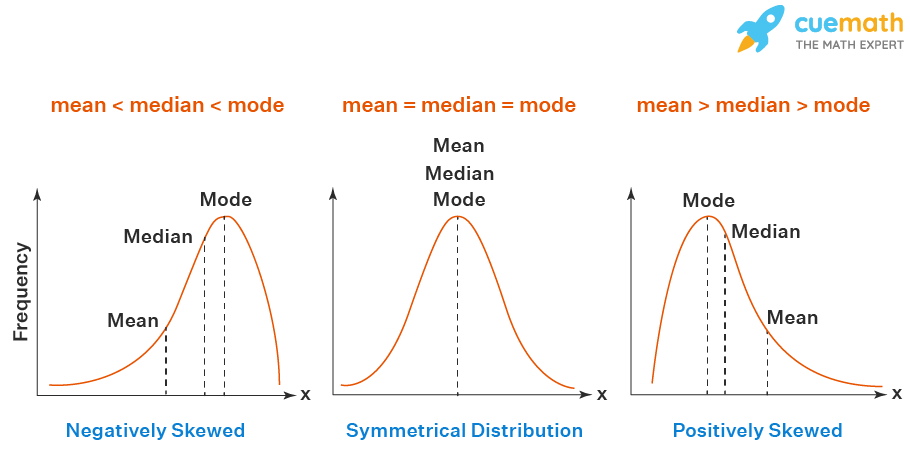

### 2.1. Histograms

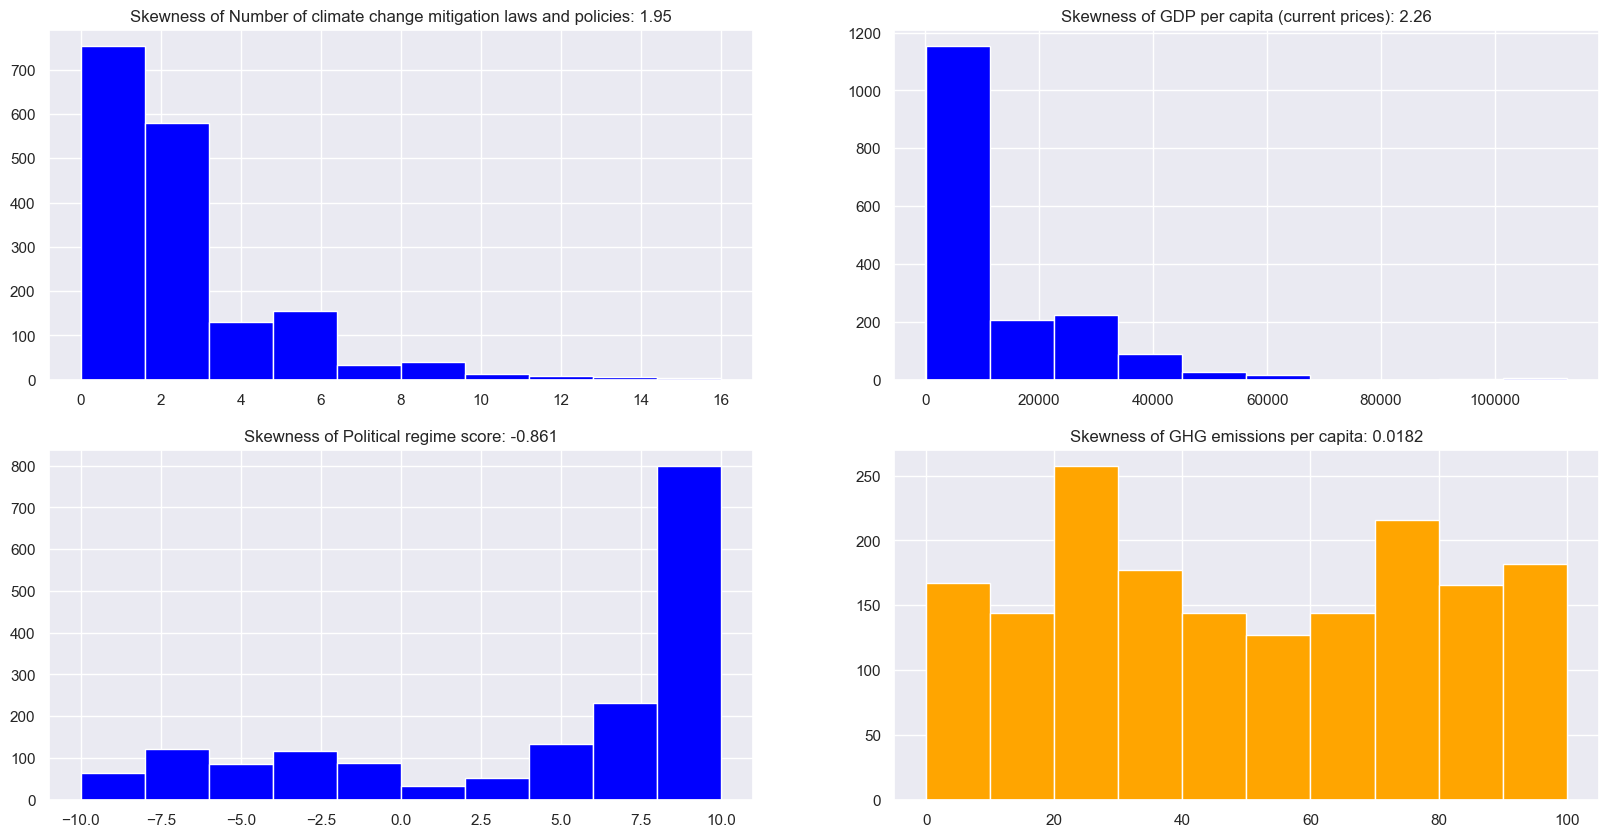

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, feature, feature_name, color in zip(axes.flatten(), all_features, all_features_names, colors):
    ax.hist(df[feature], color=color)
    ax.set_title(f"Skewness of {feature_name}: {skew(df[feature], nan_policy='omit'):.3}")

**Notes:**

1. We do not need to log-transmorm our variables since the skewness of each is in the range between -3 and 3. 
2. Indeed, as we expected, the distrivution of 'political regime score' is skewed to the left, while other variables are skewed to the right.
3. The distribution of our outcome variable is almost perfectly balanced.

### 2.2. Maps

To draw maps in a compact way we will use a custom function 'plot_a_feature_map'

In [12]:
def plot_a_feature_map(feature, feature_name, color):
    feature_map = df.groupby(['country']).mean()
    feature_map.reset_index(inplace=True)

    fig_feature_map = px.choropleth(feature_map, 
                                    locations='country',
                                    locationmode='country names',
                                    color=feature,
                                    color_continuous_scale=color)

    fig_feature_map.update_layout(title={'text': f"Spatial distribution of mean {feature_name}",
                                       'y':0.95,
                                       'x':0.5,
                                       'xanchor': 'center',
                                       'yanchor': 'top'})

    fig_feature_map.show()

**color for exp_features:** px.colors.sequential.Blues

**color for target_feature:** px.colors.sequential.Oranges

In [13]:
plot_a_feature_map(exp_feature_1, exp_feature_1_name, px.colors.sequential.Blues)

/var/folders/_2/fq28qryj11g4b72xcm9l0b180000gn/T/ipykernel_32666/4108627173.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Notes:**

1. More laws are in South America countries (Brazil, Argentina) and UK. A little bit less in asian (India, Japan, Indonesia, Vietnam)
2. Less laws are African countries
3. Probably there is a link with awareness

In [14]:
plot_a_feature_map(exp_feature_2, exp_feature_2_name, px.colors.sequential.Blues)

/var/folders/_2/fq28qryj11g4b72xcm9l0b180000gn/T/ipykernel_32666/4108627173.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Notes:**

1. The wealthiest conutries are in EU, North America and Australia
2. The poorest countries are in Africa and Asia

In [15]:
plot_a_feature_map(exp_feature_3, exp_feature_3_name, px.colors.sequential.Blues)

/var/folders/_2/fq28qryj11g4b72xcm9l0b180000gn/T/ipykernel_32666/4108627173.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Notes:**

1. Democratic countries are mostly in North and South (except for Venezuela) Americas and EU. There are also Australia, Japan and Mongolia.
2. Autoritarian countries are mostly in Asia part of the globe: China, Kazakhstan, Vietnam.

In [16]:
plot_a_feature_map(target_feature, target_feature_name, px.colors.sequential.Oranges)

/var/folders/_2/fq28qryj11g4b72xcm9l0b180000gn/T/ipykernel_32666/4108627173.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Notes:**

1. More GHG emissions are in African and Asian countries where is cheeper to locate production factory.

### 2.3. Line trends

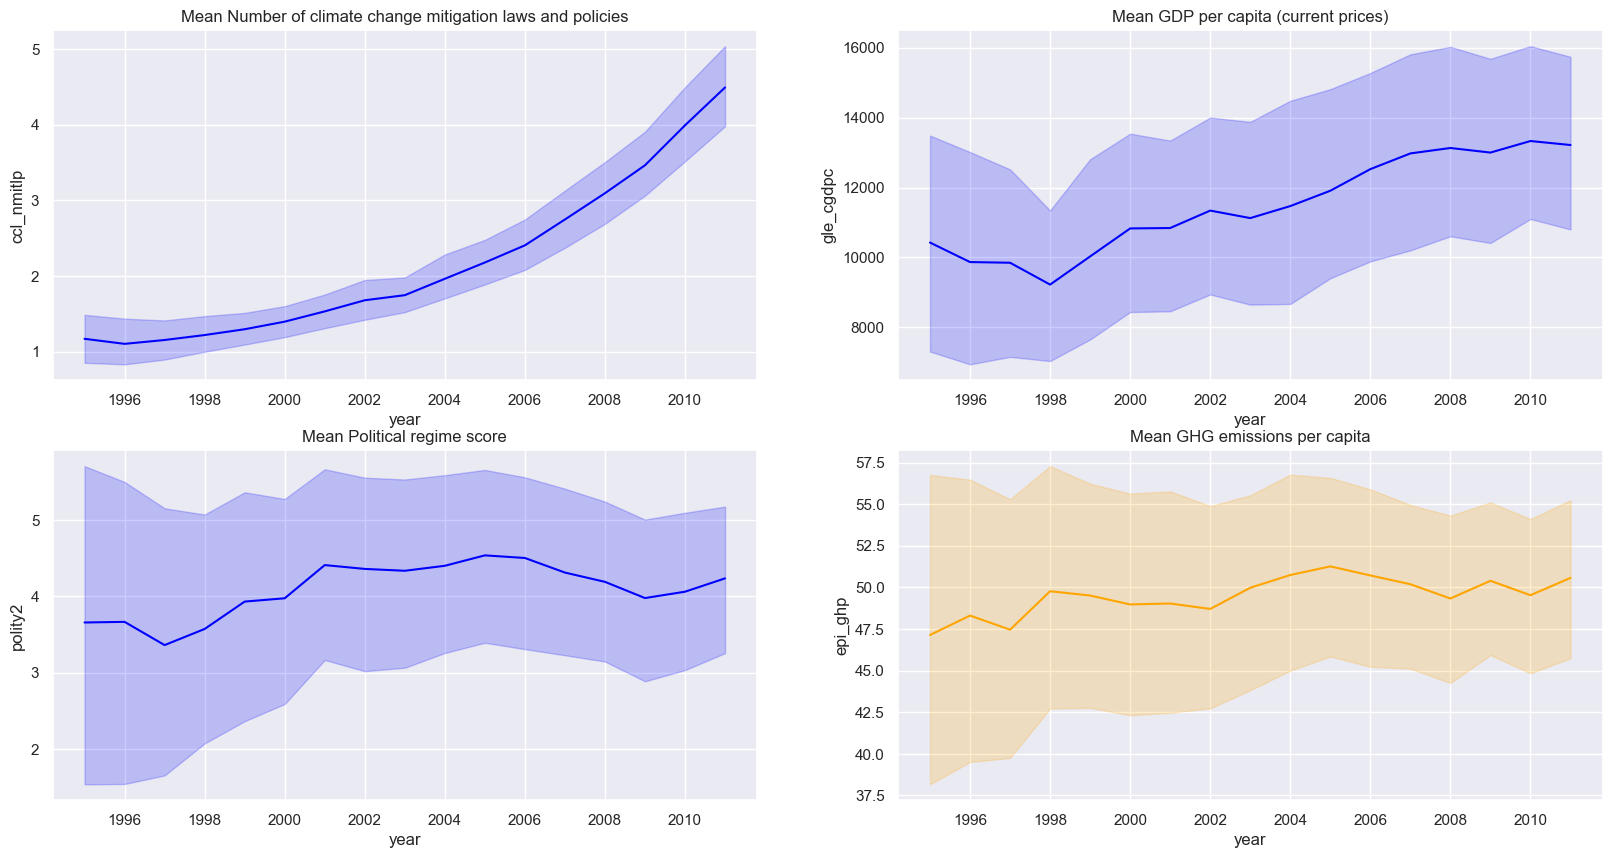

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, feature, feature_name, color in zip(axes.flatten(), all_features, all_features_names, colors):
    sns.lineplot(x='year', y=feature, data=df, ax=ax, color=color)
    ax.set_ylabel(f"{feature}")
    ax.set_title(f"Mean {feature_name}")

**Notes:**

1. Overall, there are positive trends for each feature.
2. Overall, we observe less variation year after year (the shaded area becomes smaller).
3. GDP per capita: interesting drop in 1998 (world financial crisis).
4. Political regime score: small decline after 2005. It would be interesting to explore this.
5. GHG emissions per capita: small drop in 2005 (probably due to Kyoto protocol) we wiil explore this event deeply.

## 3. Bivariative analysis

### 3.1. Scatterplot

In [18]:
def plot_features_against_target(target_feature, target_feature_name,
                                 features, feature_names,
                                 colors=None, color_base=None):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(20, 20))
    
    palette = None
    if color_base is not None:
        colors = [None] * len(features)
        palette = "Spectral"
    elif colors is None:
        colors = ['red'] * len(features)

    for ax, feature, feature_name, color in zip(axes.flatten(), features, feature_names, colors):
        sns.scatterplot(x=feature, y=target_feature, data=df,
                        ax=ax, legend=True,
                        hue=color_base, color=color, palette=palette)
        ax.set_xlabel(f"{feature_name}")
        ax.set_ylabel(f"{target_feature_name}")

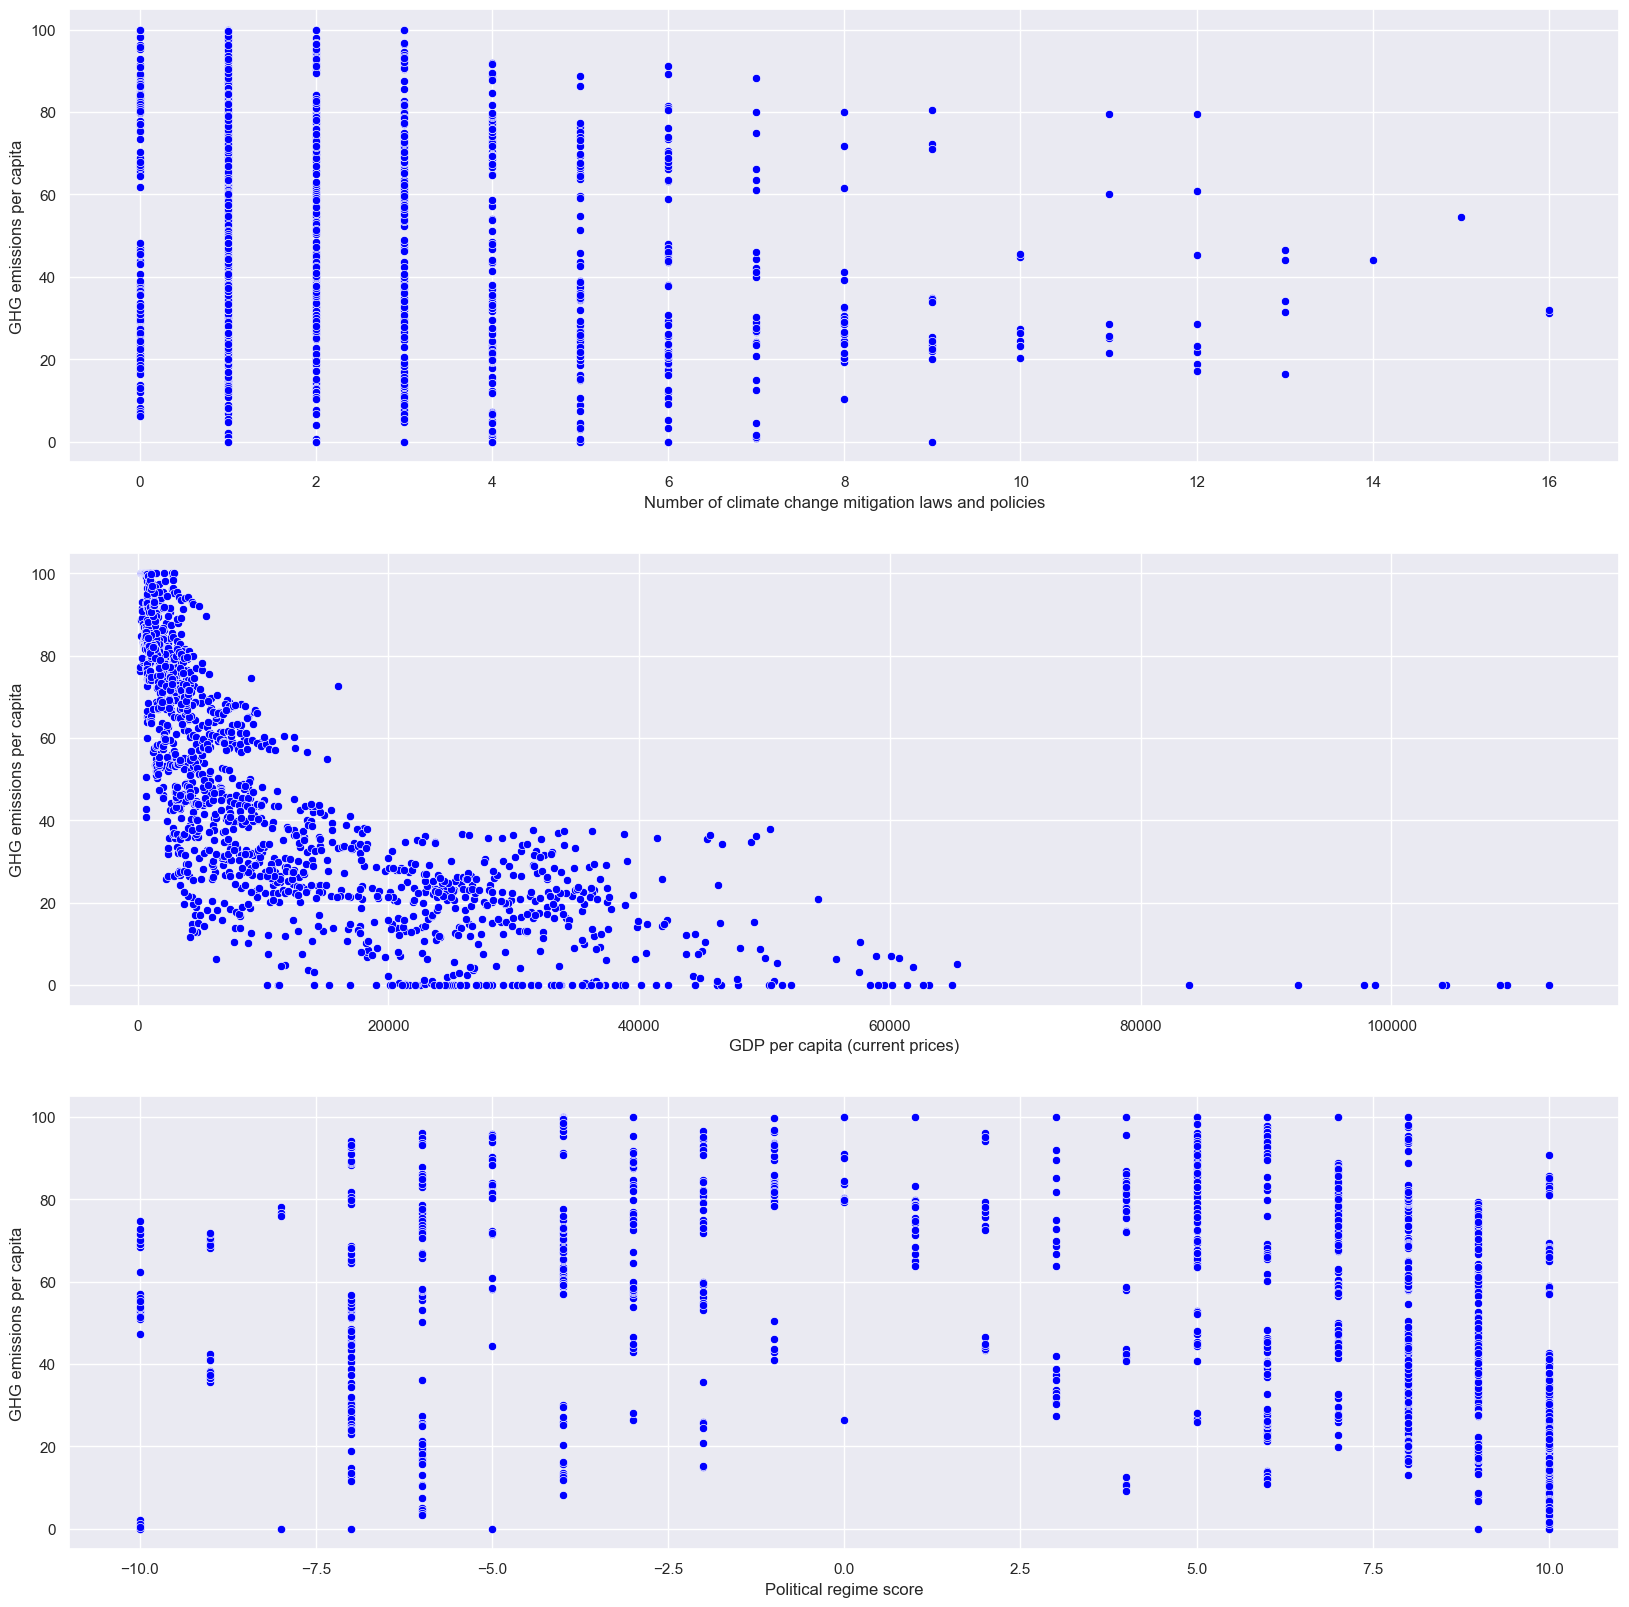

In [19]:
plot_features_against_target(target_feature=target_feature, target_feature_name=target_feature_name,
                             features=features, feature_names=feature_names,
                             colors=colors, color_base=None)

So, it is not so cleaer from this plot what should we do next. Let's try different colorisation ways in order to understand what is better for us.

### 3.2 Scatteplots with colorisation by percentiles

first, we need to create new column with percentiles values and add them in our dataframe.

In [20]:
new_columns = ['laws_quantiles', 'gdp_pc_quantiles', 'polity2_quantiles', 'ghg_pc_quantiles']

for column, feature in zip(new_columns, features):
    df[column] = pd.qcut(df[feature], q=5, precision=0, duplicates="drop")

Then, we will use a custom function to plot the same scatterplots but with different colorisation base:

In [21]:
def scatteplot_color_base(color_base):
    plot_features_against_target(target_feature=target_feature, target_feature_name=target_feature_name,
                                 features=features, feature_names=feature_names,
                                 colors=None, color_base=color_base)

#### a) Number of climate change mitigation laws and policies

**Notes:**

1. Personally, I do not see any pattern here

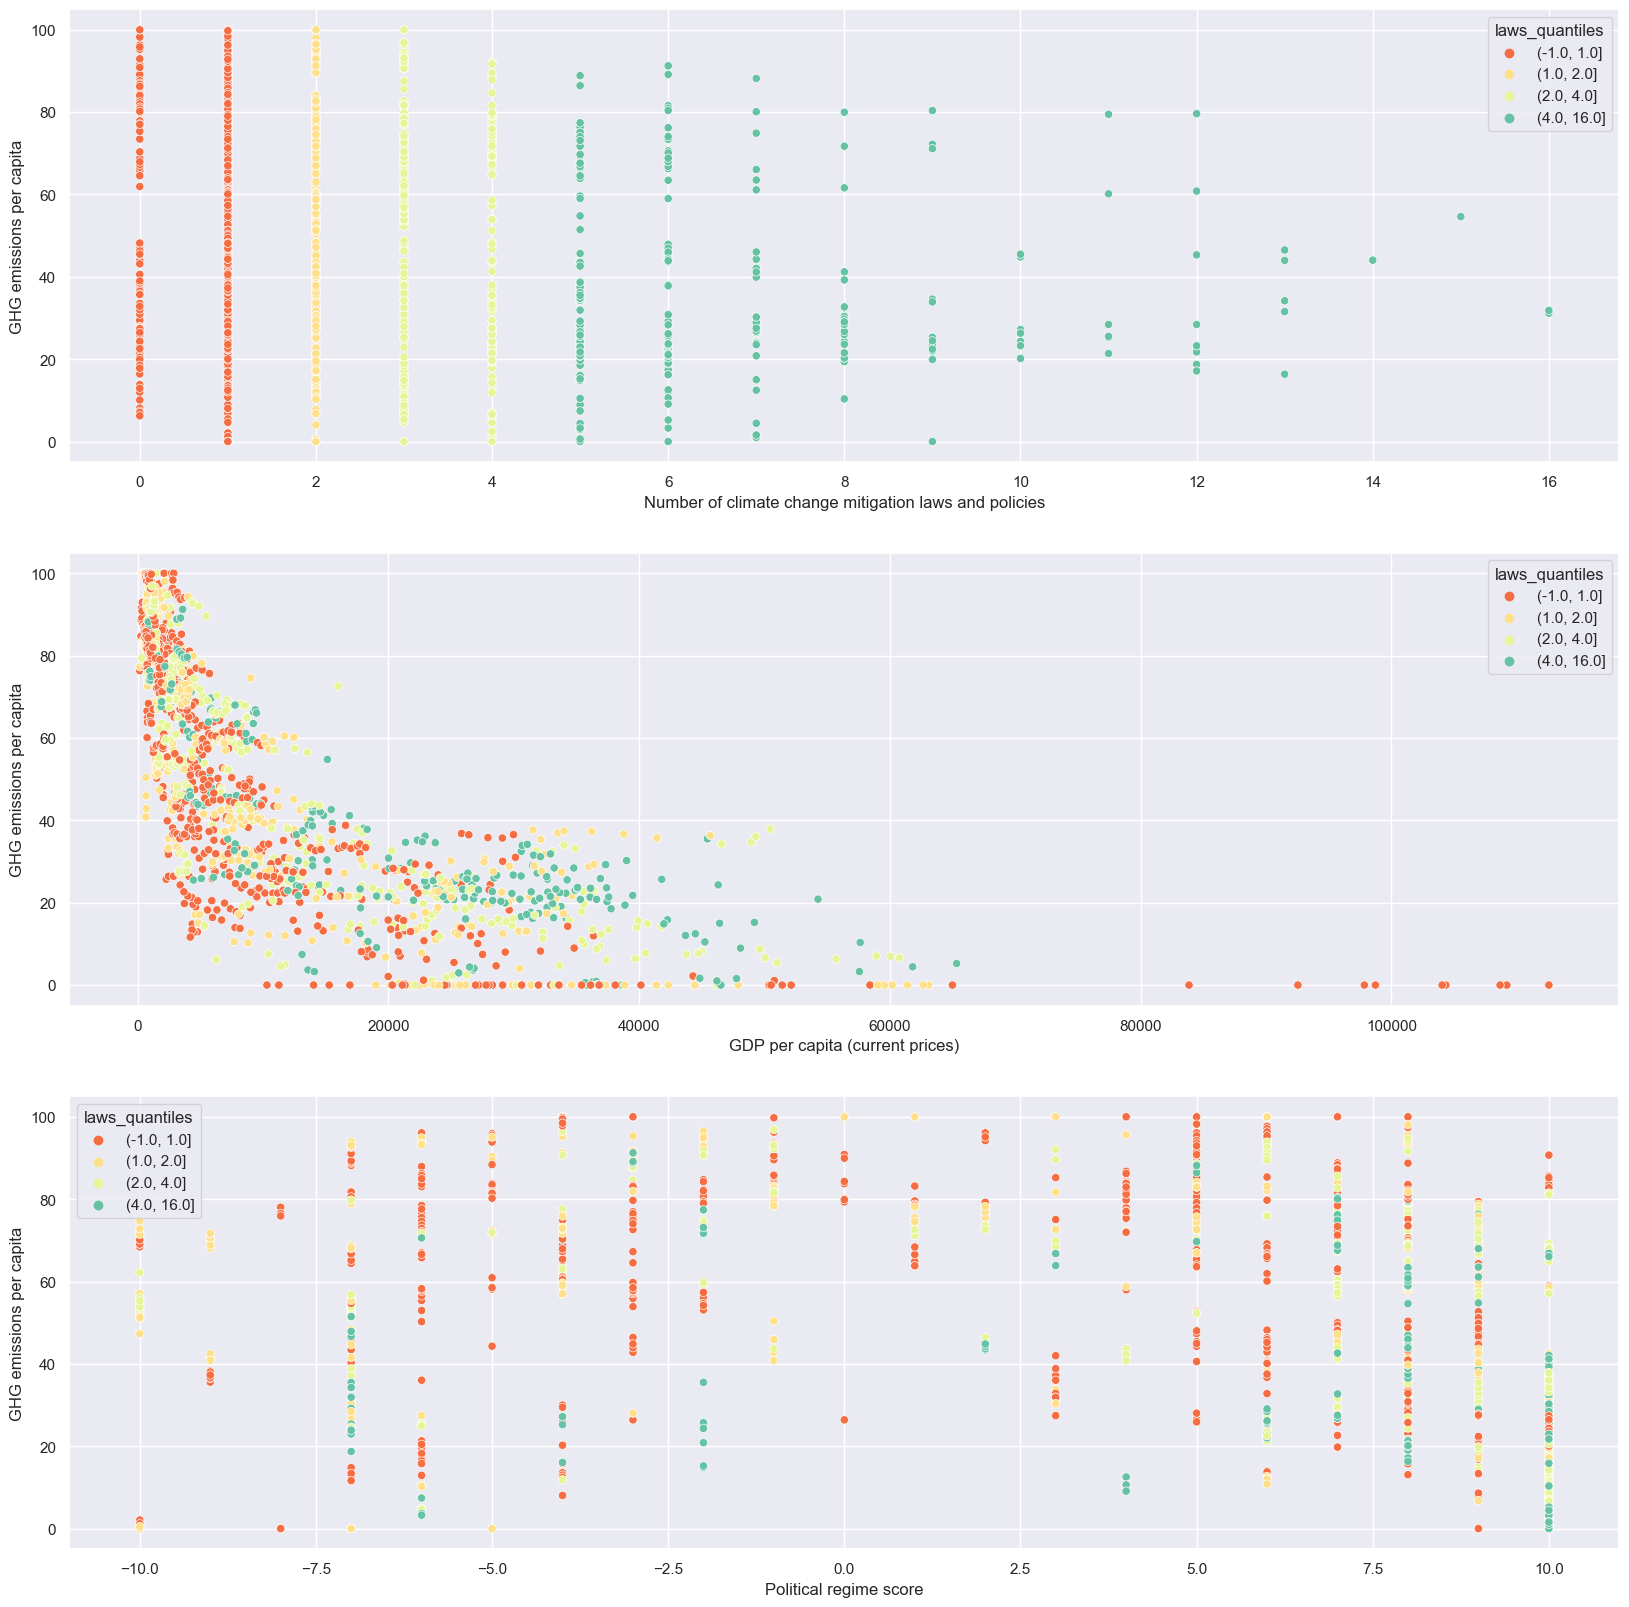

In [22]:
scatteplot_color_base('laws_quantiles')

#### b) GDP per capita (current prices)

**Notes:**

1. Countries with higher gdp per capita level are located in the bottom part of the graph, meaning that they have less GHG emissions
2. 2nd best percentile (light green dots) are almost replicate the positions of the 1st percentile (blue dots). However, they have more variance since their vertical range is higher than the range of blue dots.

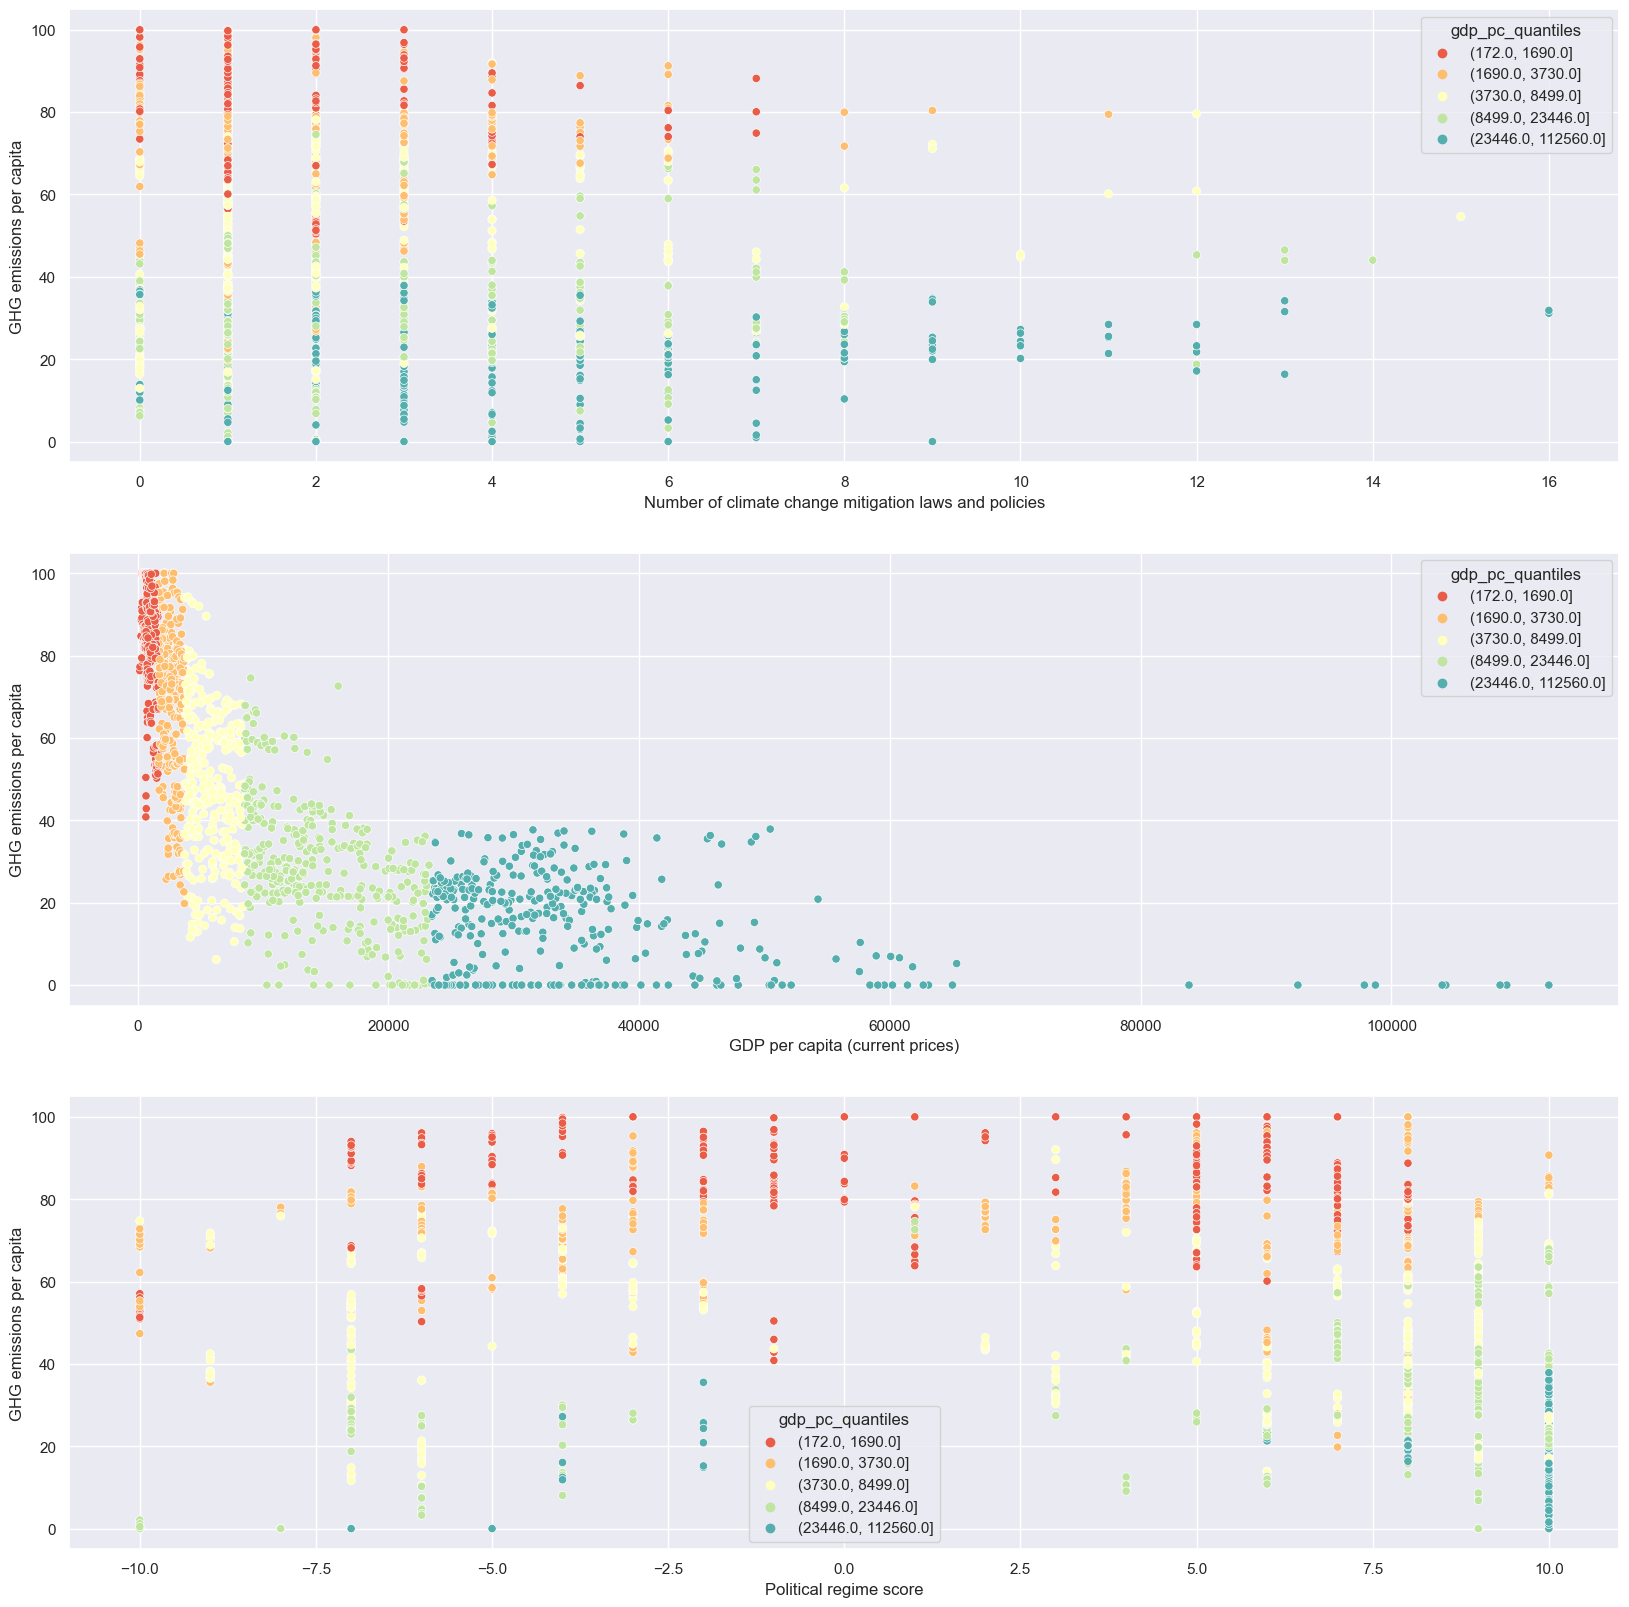

In [23]:
scatteplot_color_base('gdp_pc_quantiles')

#### c) Political regime score

**Notes:**
1. Amount of GHG emissions are slightly related to political regime in the country. We can see (on the 2nd subplot) that a lot of democratic states (blues dots; score > 8) are more or less in the bottom part of the plot, while a lot of autocratic states (red and orange dots; score < 5) are concentrated in the top part. 

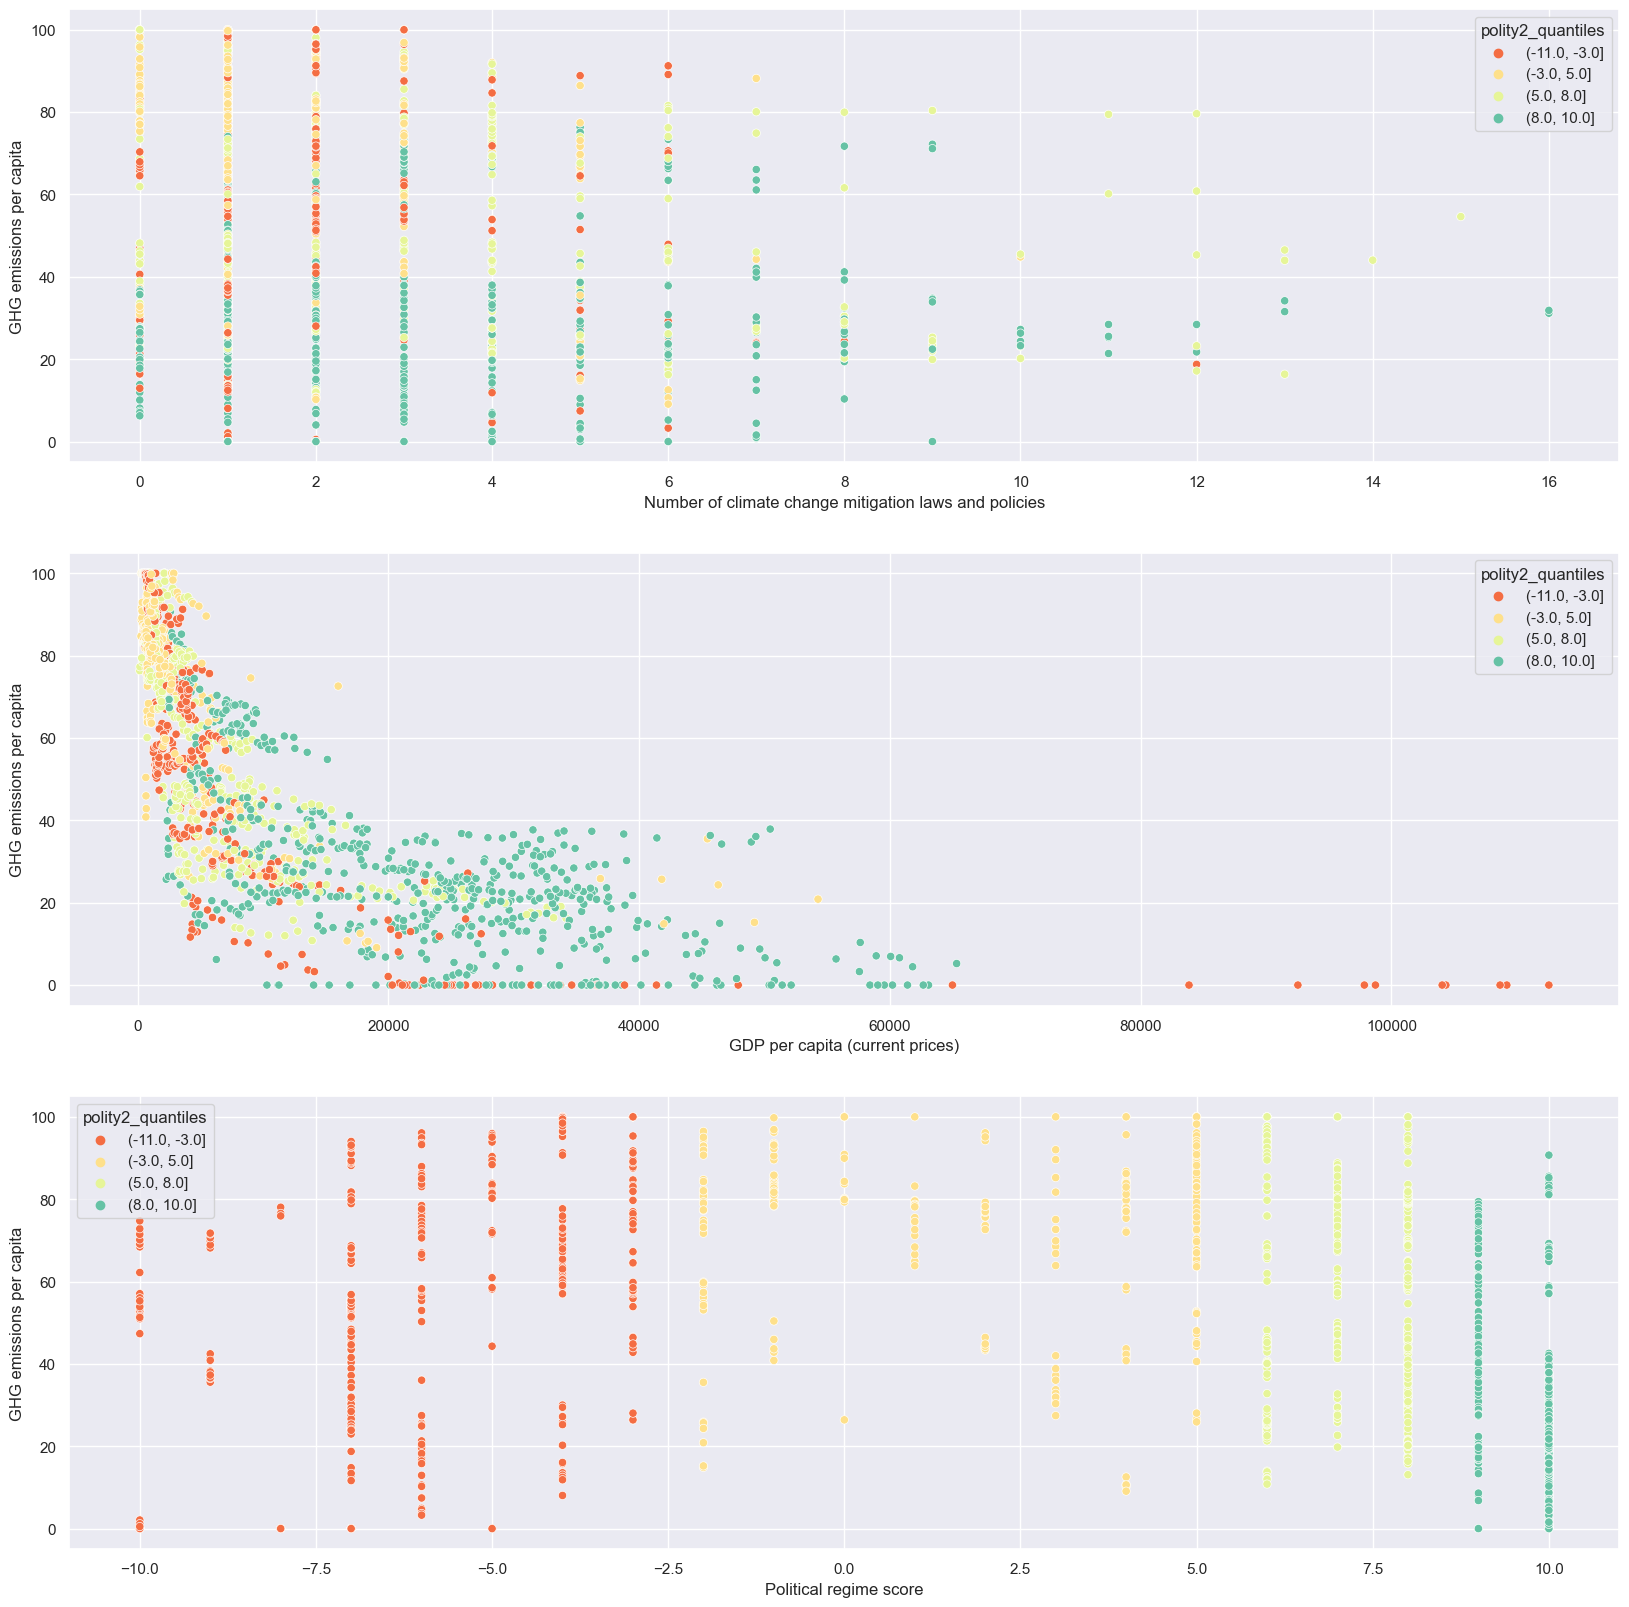

In [24]:
scatteplot_color_base('polity2_quantiles')

Let's observe some correlation coefficients:

In [25]:
correlation = df[['ccl_nmitlp', 'gle_cgdpc', 'polity2', 'epi_ghp']].corr()

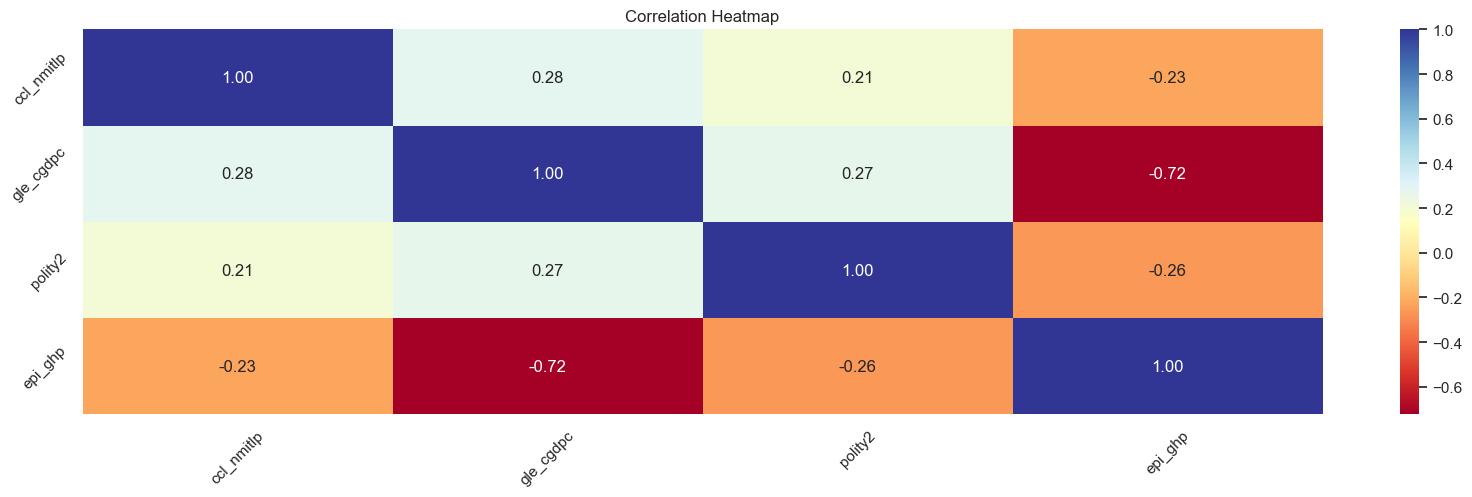

In [26]:
sns.heatmap(correlation, cmap="RdYlBu", annot=True, fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Correlation Heatmap")
plt.show()

Ok! Our target variable (GHG emissions per capita) correlates with:
 1. GDP per capita (high negative relationship: -0.72): the poorer the country the more emissions it has
 2. Polity2 score (slight negative relationship: -0.26): the more democratic the country the less emissions it has
 3. Number of CC mitigitaion laws and policies (slight negative relationship: -0.23): the more laws are in place the less emissions

So, it seems logical to have these variables (or at least only the GDP per capita) in our model that we will use in causal analysis. However, let's dig a little more to understand the level of importance of all these features.

## 4. Building a model (first steps)

First, we need to separate our features

In [27]:
target = df[target_feature]
features = df.drop(['index', 'country', 'year', 'ccodealp_year', 'laws_quantiles', 'gdp_pc_quantiles', 'polity2_quantiles', target_feature], axis=1)

now, we need to split data into train and test (it is almost ML :O).

In the following code:

1. 'test_size' = 0.2 means that the testing set will be 20% of the total dataset
2. 'random_state' is the seed for the random number generator that is used to shuffle the data before splitting it into training and testing sets. with fixed value, we will get reproducible results

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size=0.2, random_state=42)

In [29]:
# Create a linear model

model_lr = LinearRegression()

In [30]:
# Train the linear model

model_lr.fit(X_train, y_train)

LinearRegression()

In [31]:
# Make predictions on train and test data

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

let's look inside our regressor. Linear models explain the importance of each feature in a very easy way: the bigger the coefficient (by absolute value) before a feature the bigger the importance of this feature for the prediction.

<BarContainer object of 3 artists>

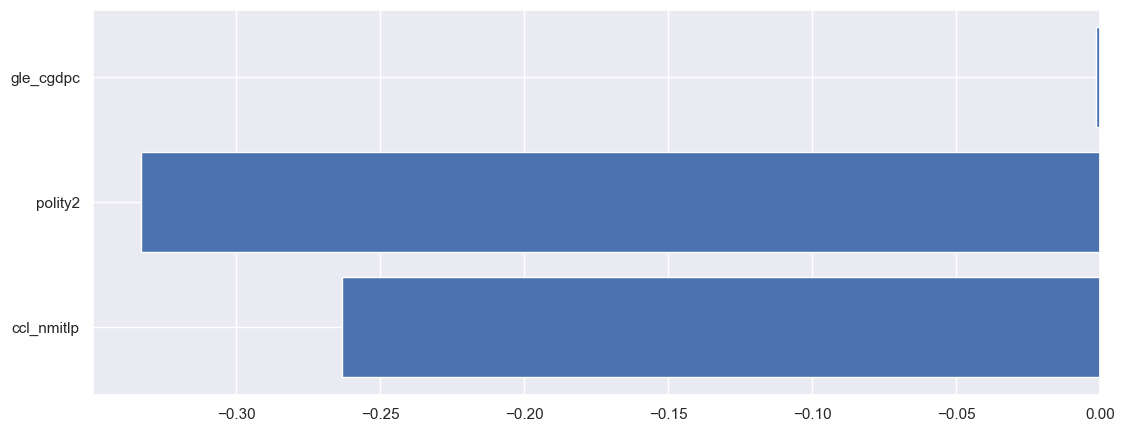

In [32]:
plt.figure(figsize=(13, 5))
plt.barh(features.columns, model_lr.coef_)

Wow! it looks like 'polity2' feature is the most important in our model (**importatnt: data here is not normalized**), while GDP per capita is the least one. It is quite surprisingly since we were thinking the opposite things before.

### 4.1. Data standartisation

For building a linear model **data normalization** is essential:

> Standardization is a linear transformation that is applied to each feature independently.
First, mean $\hat{\mu_i}$ and variance $\hat{\sigma_i}$ of the $i$-th feature are estimated, after that we subtract the mean from every value and divide the result by variance:

$$\frac{x_{ij}-\hat{\mu_i}}{\hat{\sigma_i}}$$

>After that, each feature will have zero mean and variance of 1. This operation needs to be performed on the train data first, and then the same means and variances are to be used to modify the test set. This way we will not introduce any _leaks_ of information about the data in our test set.


In [33]:
# Standartize train and test data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Fit the Linear model again on scaled data

model_lr_scaled = LinearRegression()
model_lr_scaled.fit(X_train_scaled, y_train)

LinearRegression()

<BarContainer object of 3 artists>

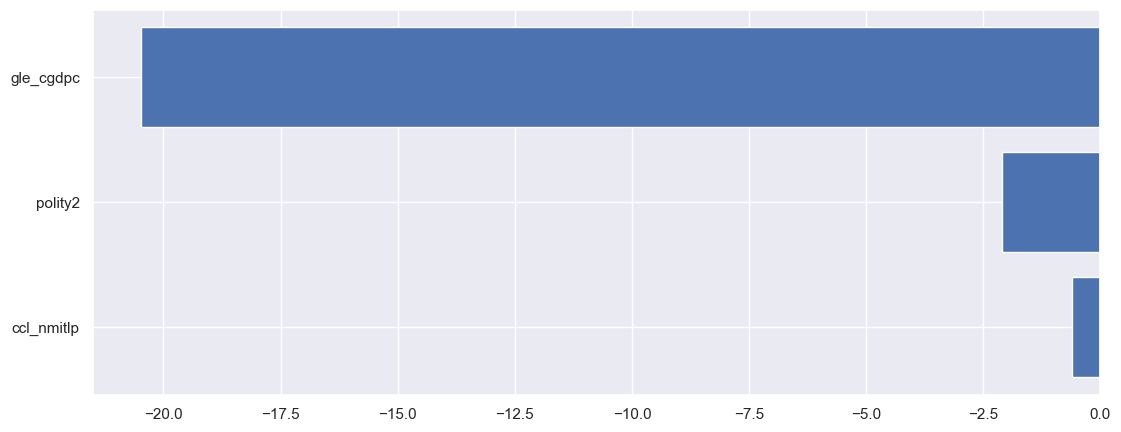

In [35]:
# Plot a bar chart of feature importances on normalized data

plt.figure(figsize=(13, 5))
plt.barh(features.columns, model_lr_scaled.coef_)

Well, haha, now we have exactly what we expected! 

'gle_cgdpc' (GDP per capita) feature is the most important in our model (**with normalized data**).

## 4. Causal analysis

Well, okey! Since the time span for our subset is from 1995 to 2011, **we need to find shock event that happend between 2000 - 2005.**

Below there is the list of possible events:

   - The Marrakesh Accords are adopted at COP7, detailing the rules for the implementation of the Kyoto Protocol, setting up new funding and planning instruments for adaptation, and establishing a technology transfer framework to support developing countries in addressing climate change (November, 2001)
   - [Johannesburg Declaration on Sustainable Development](https://www.un.org/esa/sustdev/documents/WSSD_POI_PD/English/POI_PD.htm) (2002) -> 190 countries adopted
   - [The EU's Emissions Trading System is launched](https://www.europarl.europa.eu/news/en/headlines/society/20170213STO62208/the-eu-emissions-trading-scheme-ets-and-its-reform-in-brief), the world's first and largest emissions trading scheme, is launched as a major pillar of EU climate policy. (January, 2005) -> 30 countries: the 27 EU member states + Iceland, Liechtenstein and Norway
   - Kyoto protocol (February, 2005) -> 192 countries
    
However, it seems that it would be easier to separate countries into treatment and control with the use of EU's Emissions Trading System. So, let's work with it!

Let's first create a dummy variable that would indicate the membership status of ETS: 'ETS_membership'.

In [36]:
df['ETS_membership'] = 1

In [37]:
# the list of ETS members

ETS_members = ['Austria', 'Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Finland', 'Germany', 'Greece', 
                'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal', 
                'Slovakia', 'Spain', 'Sweden', 'United Kingdom of Great Britain and Northern Ireland',]

for i, row in df.iterrows():
    if row["country"] in ETS_members:
        df.at[i, "ETS_members"] = 1
    else:
        df.at[i, "ETS_members"] = 0

In [38]:
df_mean_ghg_pc = df.groupby(['year', 'ETS_members'])['epi_ghp'].agg(['mean'])
df_mean_ghg_pc.reset_index(inplace=True)
# df_mean

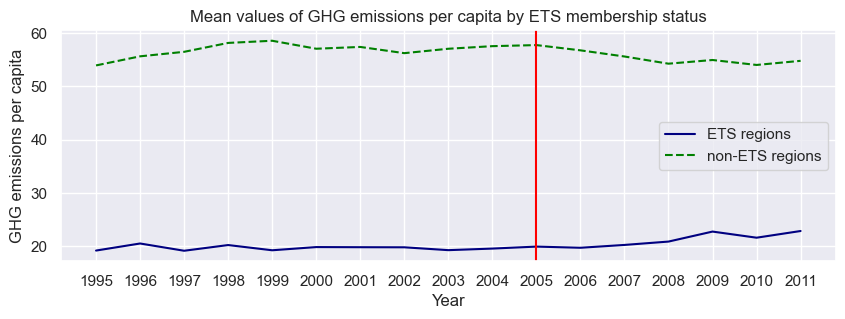

In [39]:
plt.figure(figsize=(10, 3))

plt.plot(df_mean_ghg_pc[(df_mean_ghg_pc['ETS_members'] == 1)]['year'],
         df_mean_ghg_pc[(df_mean_ghg_pc['ETS_members'] == 1)]['mean'],
         color = "navy", linestyle = '-', label = "ETS regions")

plt.plot(df_mean_ghg_pc[(df_mean_ghg_pc['ETS_members'] == 0)]['year'],
         df_mean_ghg_pc[(df_mean_ghg_pc['ETS_members'] == 0)]['mean'],
         color = "green", linestyle = '--', label = "non-ETS regions")

plt.axvline(x=2005, ymin=0, ymax=100, color='red')
plt.legend()
plt.xlabel("Year")
plt.ylabel(target_feature_name)
plt.title(f"Mean values of {target_feature_name} by ETS membership status")
plt.xticks(df["year"].unique())

plt.show()

In [40]:
df_mean_gdp_pc = df.groupby(['year', 'ETS_members'])['gle_cgdpc'].agg(['mean'])
df_mean_gdp_pc.reset_index(inplace=True)
# df_mean

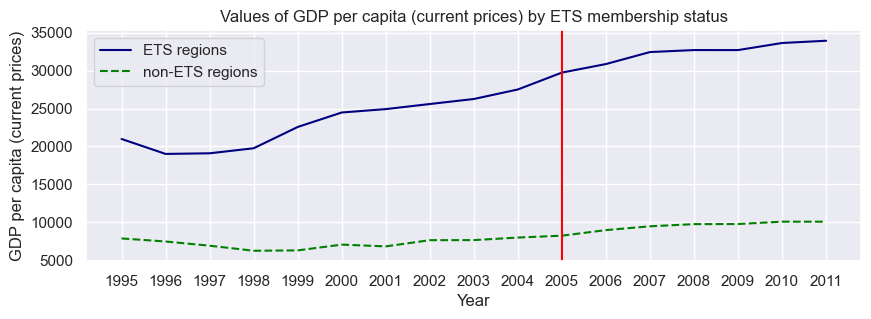

In [41]:
plt.figure(figsize=(10, 3))

plt.plot(df_mean_gdp_pc[(df_mean_gdp_pc['ETS_members'] == 1)]['year'],
         df_mean_gdp_pc[(df_mean_gdp_pc['ETS_members'] == 1)]['mean'],
         color = "navy", linestyle = '-', label = "ETS regions")

plt.plot(df_mean_gdp_pc[(df_mean_gdp_pc['ETS_members'] == 0)]['year'],
         df_mean_gdp_pc[(df_mean_gdp_pc['ETS_members'] == 0)]['mean'],
         color = "green", linestyle = '--', label = "non-ETS regions")

plt.axvline(x=2005, ymin=0, ymax=100, color='red')
plt.legend()
plt.xlabel("Year")
plt.ylabel(exp_feature_2_name)
plt.title(f"Values of {exp_feature_2_name} by ETS membership status")
plt.xticks(df["year"].unique())

plt.show()

# !!! restricted area: a lot of machine lerning stuff !!!

## 4. Building a model

### 4.1. First model training

In [42]:
# Separate features and the target

target = df[target_feature]
features = df.drop(['index', 'country', 'year', 'ccodealp_year', 'laws_quantiles', 'gdp_pc_quantiles', 'polity2_quantiles', target_feature], axis=1)

In [43]:
# split the data into train and test
# 'test_size' = 0.2 means that the testing set will be 20% of the total dataset
# 'random_state' is the seed for the random number generator that is used to shuffle the data before splitting it 
#      into training and testing sets. with fixed value, we will get reproducible results

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size=0.2, random_state=42)

In [44]:
# Create a linear model

model_lr = LinearRegression()

In [45]:
# Train the linear model

model_lr.fit(X_train, y_train)

LinearRegression()

In [46]:
# Make predictions on train and test data

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

let's observe MSE.

The Mean Squared Error (MSE) is a measure of the difference between the predicted values and the true values in a regression problem. It is calculated as the average of the squared differences between the predicted values and the true values.

In [47]:
# Report MSE of both train and test predictions

mse_lr_train = mean_squared_error(y_train, y_train_pred)
mse_lr_test = mean_squared_error(y_test, y_test_pred)

print('Train Mean Squared Error: %.2f' % mse_lr_train)
print('Test Mean Squared Error: %.2f' % mse_lr_test)

Train Mean Squared Error: 422.32
Test Mean Squared Error: 397.00


Well, since our target variable values are in the range between 0 and 100, these MSE results are not so good. So, this first model is making large errors.

In [48]:
# Report R2 score of both train and test predictions

r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print('Train Variance Score: %.2f' % r2_score_train)
print('Test Variance Score: %.2f' % r2_score_test)

Train Variance Score: 0.52
Test Variance Score: 0.58


Meanwhile, it explains only 51 and 58 % of train and test data samples.

### 4.2. Data standartisation

For building a linear model **data normalization** is essential:

> Standardization is a linear transformation that is applied to each feature independently.
First, mean $\hat{\mu_i}$ and variance $\hat{\sigma_i}$ of the $i$-th feature are estimated, after that we subtract the mean from every value and divide the result by variance:

$$\frac{x_{ij}-\hat{\mu_i}}{\hat{\sigma_i}}$$

>After that, each feature will have zero mean and variance of 1. This operation needs to be performed on the train data first, and then the same means and variances are to be used to modify the test set. This way we will not introduce any _leaks_ of information about the data in our test set.


In [49]:
# Standartize train and test data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Fit the Linear model again on scaled data

model_lr_scaled = LinearRegression()
model_lr_scaled.fit(X_train_scaled, y_train)

LinearRegression()

In [51]:
# Make predictions

y_train_scaled_pred = model_lr_scaled.predict(X_train_scaled)
y_test_scaled_pred = model_lr_scaled.predict(X_test_scaled)

mse_lr_train_scaled = mean_squared_error(y_train, y_train_scaled_pred)
mse_lr_test_scaled = mean_squared_error(y_test, y_test_scaled_pred)

print('Train MSE after scaling: %.2f' % mse_lr_train_scaled)
print('Test MSE after scaling: %.2f' % mse_lr_test_scaled)

Train MSE after scaling: 422.32
Test MSE after scaling: 397.00


Hmmm... scaling didn't improve the preformance: both MSE results are the same as in out first attempt. Then, let's apply different models.

### 4.3. Different types of models

Along with simple Ordinary Least Squares, you will take a look at two additional algorithms that fit a linear refression model to the data:
- Ridge Regression
- Lasso Regression.

Let's see how they react to the scaling of the data.

In [52]:
def report_mse(model, X, y):
    """
    Reports MSE of the model on given data
    ---
    
    Parameters
    ---
    
        model - trained sklearn model
    
        X - array, (n_observations, n_features) matrix, used to predict target
    
        y - array, (n_observation) array of true target
     
    Returns
    ---
    
        mse - mean squared error between true target and predicted target
    """
    
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    
    return mse

In [53]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scale=False):
    """
    Trains model on train and reports its perfomance on train and test data.
    ---
    
    Parameters
    ---
    
        model - sklearn regression model (not trained)
    
        X_train  - array, (n_observations_train, n_features) matrix, train data.
     
        y_train - array, (n_observation_train) array of train target
     
        X_test  - array, (n_observations_test, n_features) matrix, train data.
     
        y_test - array, (n_observation_test) array of test target
     
        scale - bool, whether to scale the data before training, default False
     
    
    Returns
    ---
    
        mse_train - float, mean squared error of the train prediction
     
        mse_test - float, mean squared error of the test prediction
    """
    
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)

        mse_train = report_mse(model, X_train_scaled, y_train)
        mse_test = report_mse(model, X_test_scaled, y_test)
    else:
        model.fit(X_train, y_train)
        
        mse_train = report_mse(model, X_train, y_train)
        mse_test = report_mse(model, X_test, y_test)
    
    return mse_train, mse_test

In [54]:
# fit Ridge regression model on scaled data and evaluate it

model_ridge = Ridge(alpha=10**4)

mse_ridge_train_scaled, mse_ridge_test_scaled = evaluate_model(model_ridge, X_train, y_train, X_test, y_test, scale=True)

print('Train MSE Ridge Model: %.2f' % mse_ridge_train_scaled)
print('Test MSE Ridge Model: %.2f' % mse_ridge_test_scaled)

Train MSE Ridge Model: 736.66
Test MSE Ridge Model: 800.59


In [55]:
# fit Lasso regression model on scaled data and evaluate it

model_lasso = Lasso(alpha=10**4)

mse_lasso_train_scaled, mse_lasso_test_scaled = evaluate_model(model_lasso, X_train, y_train, X_test, y_test, scale=True)

print('Train MSE Lasso Model: %.2f' % mse_lasso_train_scaled)
print('Test MSE Lasso Model: %.2f' % mse_lasso_test_scaled)

Train MSE Lasso Model: 883.32
Test MSE Lasso Model: 956.18


It seems that even with models we have poor MSE results :/

P.S. alpha - **learning rate** is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

### 4.4. Analysing trained models

Ok, let's look inside our regressor and try to interpret the obtained coefficients. Linear models provide easy explanations of it: the bigger the coefficient (by absolute value) before a feature the bigger the importance of this feature for the prediction.

<BarContainer object of 5 artists>

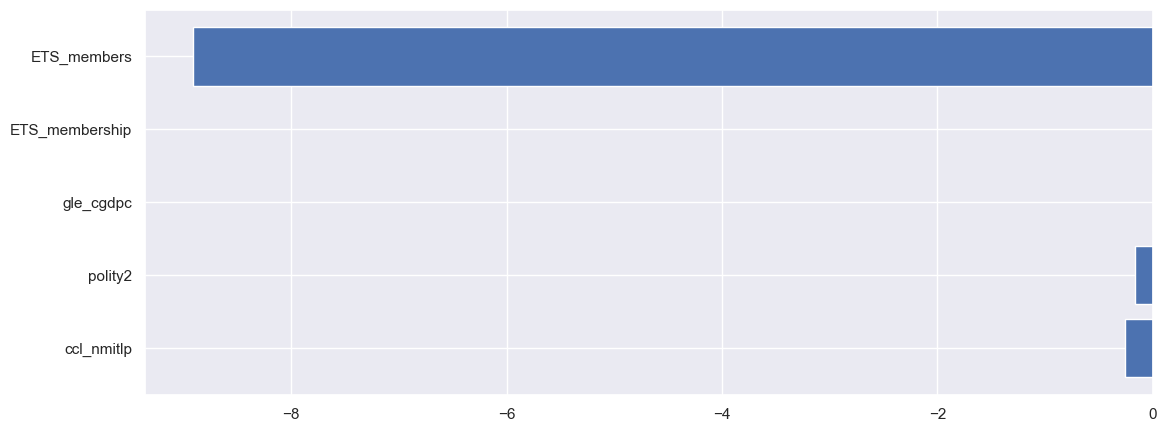

In [56]:
# Plot a bar chart of feature importances on unnormalized data

plt.figure(figsize=(13, 5))
plt.barh(features.columns, model_lr.coef_)

Wow! it looks like 'polity2' feature is the most important in our model (**with not normalized data**), while GDP per capita is the least one. It is quite surprisingly since we were thinking the opposite things before.

<BarContainer object of 5 artists>

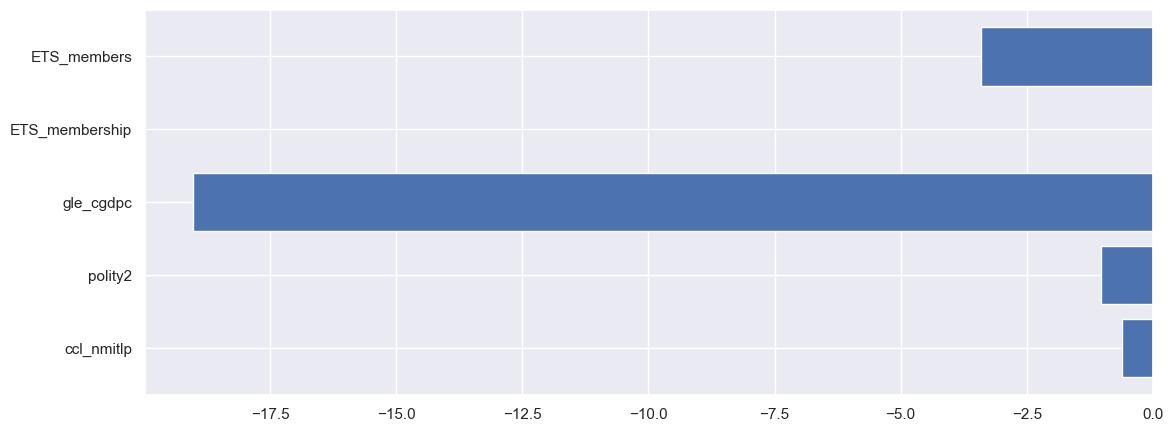

In [57]:
# Plot a bar chart of feature importances on normalized data

plt.figure(figsize=(13, 5))
plt.barh(features.columns, model_lr_scaled.coef_)

Well, haha, now we have exactly what we expected! 

'gle_cgdpc' (GDP per capita) feature is the most important in our model (**with normalized data**).

okey, let's see how Ridge and Lasso affects model coefficients. to do this we will fit Ridge Regression and Lasso models on the scaled train data.

In [58]:
# Fit the models

model_ridge = Ridge(alpha=10**4)
mse_ridge_train_scaled, mse_ridge_test_scaled = evaluate_model(model_ridge, X_train, y_train, X_test, y_test, scale=True)

model_lasso = Lasso(alpha=10**4)
mse_lasso_train, mse_lasso_test = evaluate_model(model_lasso, X_train, y_train, X_test, y_test, scale=True)

In [59]:
# Print names of largest coefficients by magnitude

def max_coef(model, names, k=3):
    """
    Return k biggest coefficients of a linear model
    ---
    
    Parameters
    ---
    
        model - trained linear model
    
        names - array-like, list of feature names
     
        k - int, number of features to return
     
    Returns
    ---
    
        top_k_features - dict, {key - feature name, value - corresponding coefficient magnitude}
    """
    
    coeffs = list(model.coef_)
    coeffs = list(map(abs, coeffs))

    indices = np.argsort(coeffs)
    indices = indices[::-1]

    ans = {}
    for i in range(k):
        index = indices[i]
        ans.update({names[index] : coeffs[index]})
    
    return ans

In [60]:
# print 3 the largest coefficients of the models

max_ridge_coef = list(max_coef(model_ridge, features.columns).values())
print(f"For Ridge: {max_ridge_coef}")

max_lasso_coef = list(max_coef(model_lasso, features.columns).values())
print(f"For Lasso: {max_lasso_coef}")

For Ridge: [2.4321189842705957, 1.44897247689065, 0.7250836587136241]
For Lasso: [0.0, 0.0, 0.0]


<AxesSubplot: >

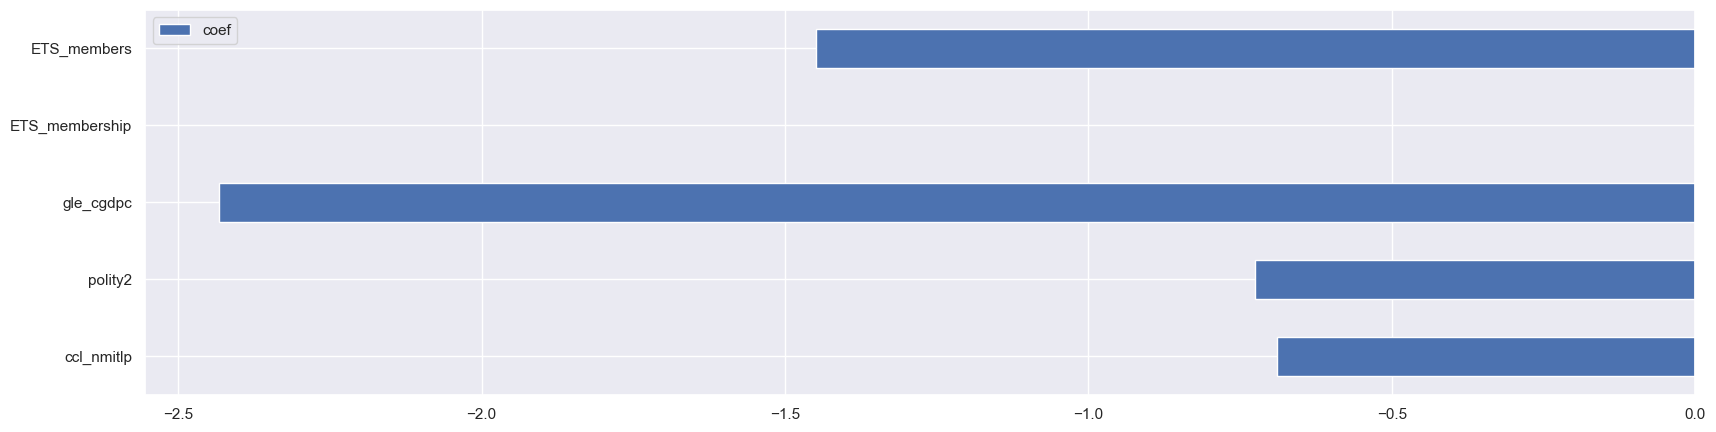

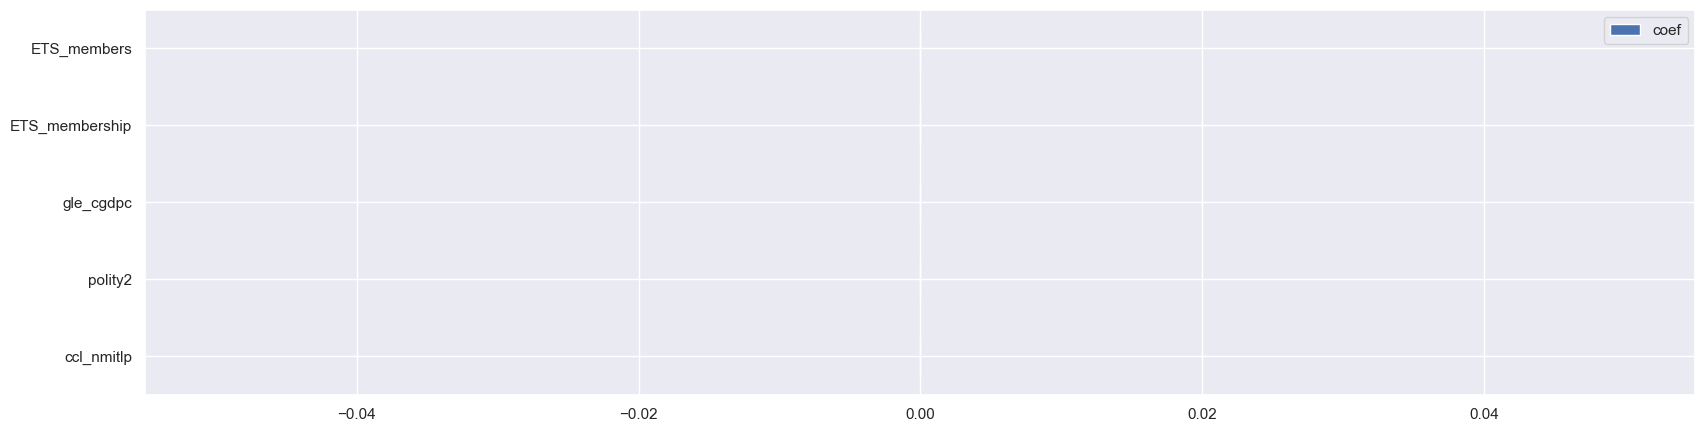

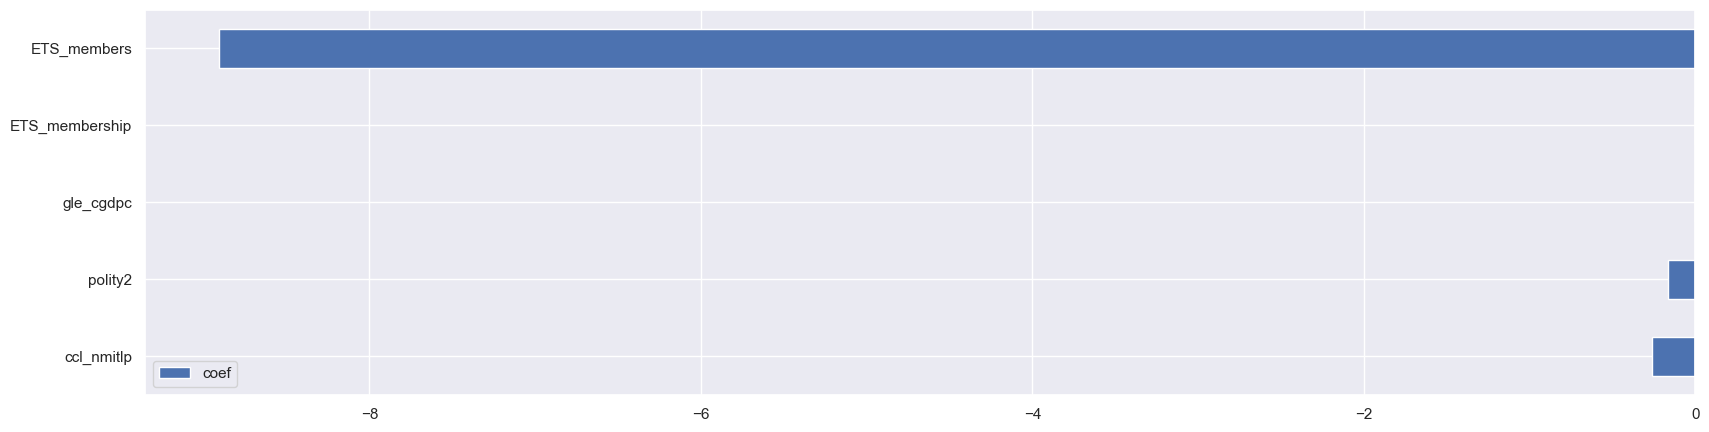

In [61]:
# Compare the results between Ridge, Lasso and simple model trained earlier

ridge_coeffs = pd.DataFrame({'coef' : model_ridge.coef_}, index=features.columns)
ridge_coeffs.plot.barh(y='coef')

lasso_coeffs = pd.DataFrame({'coef' : model_lasso.coef_}, index=features.columns)
lasso_coeffs.plot.barh(y='coef')

lr_coeffs = pd.DataFrame({'coef' : model_lr.coef_}, index=features.columns)
lr_coeffs.plot.barh(y='coef')

okey, with the use of Ridge regerssion we observe that features are actully usefull

### 4.5. Tuning regularization parameters with cross-validation

Let's try to find the best regularization parameter for Ridge Regression and Lasso using this method

In [62]:
# fit a Ridge model, best alpha score

alphas = [10**i for i in range(-6, 7)]

CV_ridge = RidgeCV(alphas=alphas)
CV_ridge.fit(X_train_scaled, y_train)

best_alpha_ridge = CV_ridge.alpha_
mse_best_alpha_ridge = report_mse(CV_ridge, X_train_scaled, y_train)

print(f'Best Alpha for Ridge Model: {best_alpha_ridge}')
print(f'Train MSE for Ridge Model with Best Alpha: {mse_best_alpha_ridge}')

Best Alpha for Ridge Model: 10.0
Train MSE for Ridge Model with Best Alpha: 422.34096009015923


In [63]:
# fit a Lasso model, best alpha score?

alphas = [10**i for i in range(-6, 7)]

CV_lasso = LassoCV(alphas=alphas)
CV_lasso.fit(X_train_scaled, y_train)

best_alpha_lasso = CV_lasso.alpha_
mse_best_alpha_lasso = report_mse(CV_lasso, X_train_scaled, y_train)

print(f'Best Alpha for Lasso Model: {best_alpha_lasso}')
print(f'Train MSE for Lasso Model with Best Alpha: {mse_best_alpha_lasso}')

Best Alpha for Lasso Model: 0.01
Train MSE for Lasso Model with Best Alpha: 422.3188205178147


In [64]:
# Compare best Ridge and Lasso model perfomance on CV and on a test set

mse_ridge_best_test = report_mse(CV_ridge, X_test_scaled, y_test)
print('Test MSE for Ridge Model with Best Alpha: ', mse_ridge_best_test)

print()

mse_lasso_best_test = report_mse(CV_lasso, X_test_scaled, y_test)
print('Test MSE for Lasso Model with Best Alpha: ', mse_lasso_best_test)

Test MSE for Ridge Model with Best Alpha:  398.1746349255307

Test MSE for Lasso Model with Best Alpha:  397.0732328521377


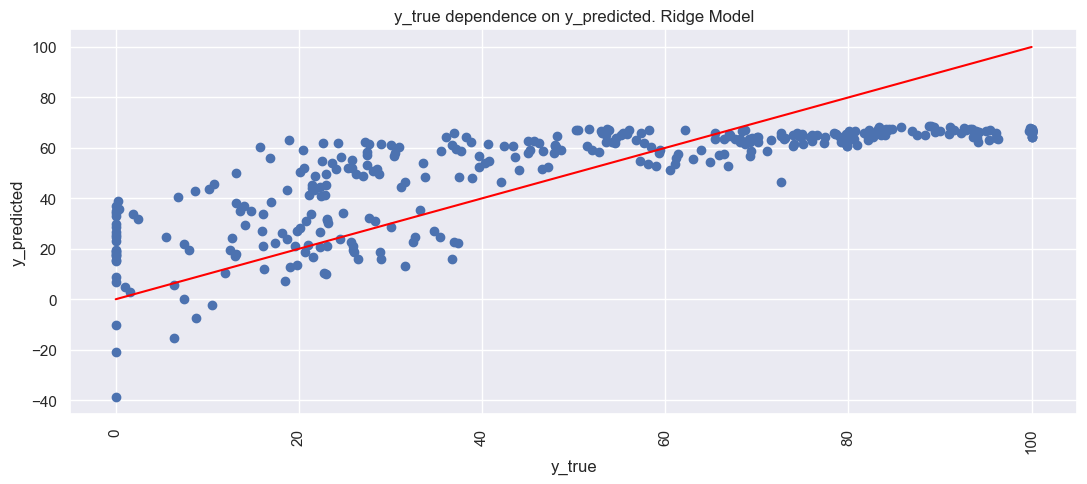

In [65]:
# Plot a scatter plot plt.scatter(y_true, y_predicted) for test observations

plt.figure(figsize=(13, 5))
plt.title('y_true dependence on y_predicted. Ridge Model')
plt.xlabel('y_true')
plt.ylabel('y_predicted')
plt.xticks(rotation='vertical')
plt.scatter(y_test, CV_ridge.predict(X_test_scaled))
plt.plot([0.0, 100.0], [0.0, 100.0], color='red')

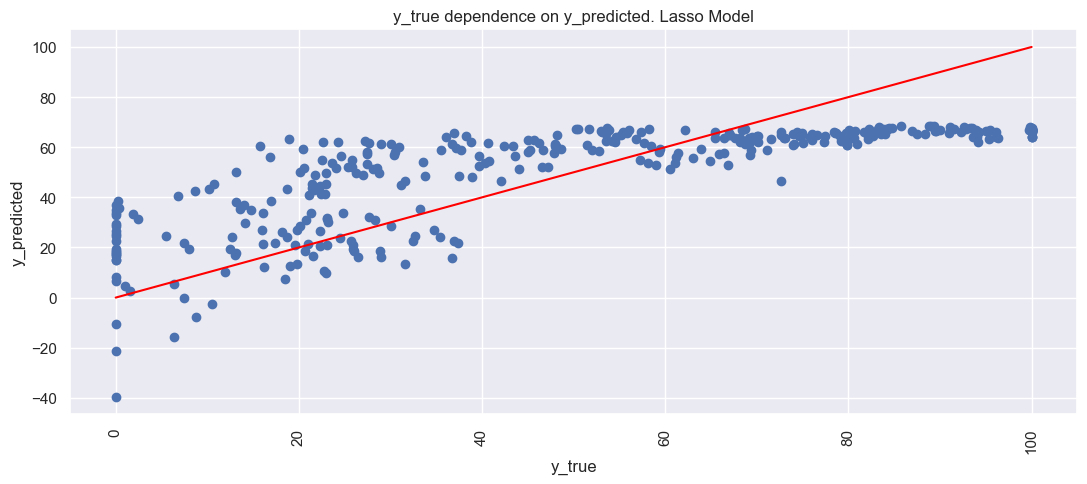

In [66]:
plt.figure(figsize=(13, 5))
plt.title('y_true dependence on y_predicted. Lasso Model')
plt.xlabel('y_true')
plt.ylabel('y_predicted')
plt.xticks(rotation='vertical')
plt.scatter(y_test, CV_lasso.predict(X_test_scaled))
plt.plot([0.0, 100.0], [0.0, 100.0], color='red')